In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler

In [2]:
#merging for BDT training
node_6=pd.read_hdf("node_6.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_SM=pd.read_hdf("node_SM.hd5")

frames=[node_6,node_9,node_4,node_SM]
df=pd.concat(frames)

#ignoring category 0
df=df[df.cat>0]
df.weight/=df.weight.mean()

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df["random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)

In [52]:
df.columns

Index([u'candidate_id', u'weight', u'mgg', u'mbb', u'leadPho_px',
       u'leadPho_py', u'leadPho_pz', u'leadPho_e', u'subleadPho_px',
       u'subleadPho_py', u'subleadPho_pz', u'subleadPho_e', u'leadJet_px',
       u'leadJet_py', u'leadJet_pz', u'leadJet_e', u'subleadJet_px',
       u'subleadJet_py', u'subleadJet_pz', u'subleadJet_e', u'rho', u'nvtx',
       u'event', u'lumi', u'processIndex', u'run', u'npu', u'puweight', u'cat',
       u'bdtcat', u'mxcat', u'leadPho_pt', u'leadPho_eta', u'leadPho_phi',
       u'leadPho_m', u'subleadPho_pt', u'subleadPho_eta', u'subleadPho_phi',
       u'subleadPho_m', u'leadJet_pt', u'leadJet_eta', u'leadJet_phi',
       u'leadJet_m', u'subleadJet_pt', u'subleadJet_eta', u'subleadJet_phi',
       u'subleadJet_m', u'hgg_px', u'hgg_py', u'hgg_pz', u'hgg_e', u'hgg_pt',
       u'hgg_eta', u'hgg_phi', u'hgg_m', u'hbb_px', u'hbb_py', u'hbb_pz',
       u'hbb_e', u'hbb_pt', u'hbb_eta', u'hbb_phi', u'hbb_m', u'hh_px',
       u'hh_py', u'hh_pz', u'hh_e', u'hh

In [3]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

In [54]:
#finding sum, count, mean of each category in weights column
df.groupby('cat')['weight'].agg(['sum','count','mean'])

,sum,count,mean
cat,,,
1,8441.220892,8433,1.000975
2,8076.924645,8202,0.984751
3,2708.455813,2788,0.971469
4,722.065805,750,0.962754
5,1607.524199,1523,1.055498
6,2891.528065,2868,1.008204
7,2198.774568,2245,0.979410
8,1026.546038,1077,0.953153
9,1551.757501,1446,1.073138


In [4]:
X = df[features]
y = df['cat'] 
w = df['weight']

scaler=RobustScaler()

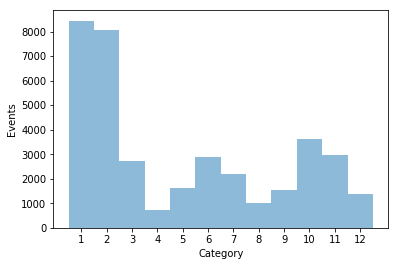

In [8]:
#plotting truth histogram
plt.figure(2)
bins=np.arange(0.5,13.5)
plt.hist(y,weights=w,bins=bins,alpha=0.5)
h=np.histogram(y,weights=w,bins=bins)
plt.ylabel('Events')
plt.xlabel('Category')
plt.xticks(np.arange(1,13))
plt.show()
plt.close()

In [57]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#classifier fitted to training set 
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf.joblib') 

CPU times: user 9min 10s, sys: 5.68 s, total: 9min 16s
Wall time: 1min 9s


['clf.joblib']

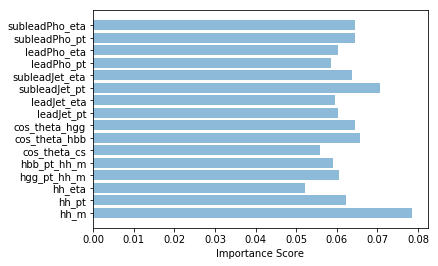

In [58]:
#features importance
clf=joblib.load('clf.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [59]:
#reweighting and clipping it at 0.5
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,0.5) 
w_train*=rw[y_train-1] #y categories are from 1-12, whereas rw array is from 0-11 

np.savetxt('rw_point5.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_point5.joblib') 

CPU times: user 8min 53s, sys: 3.64 s, total: 8min 57s
Wall time: 1min 7s


['clf_point5.joblib']

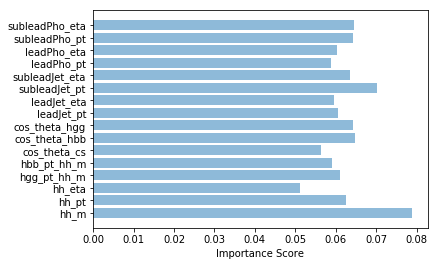

In [60]:
#features importance
clf=joblib.load('clf_point5.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [61]:
#reweighting and clipping it at 0.1
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,0.1)
w_train*=rw[y_train-1]

np.savetxt('rw_point1.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_point1.joblib') 

CPU times: user 7min 50s, sys: 4.27 s, total: 7min 54s
Wall time: 59.4 s


['clf_point1.joblib']

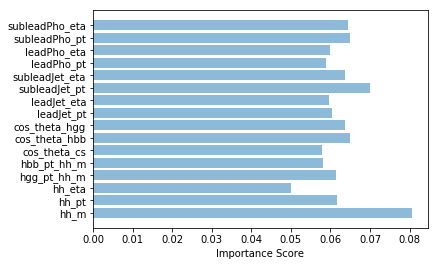

In [62]:
#features importance
clf=joblib.load('clf_point1.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [63]:
#reweighting and clipping it at 0.01
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,0.01)
w_train*=rw[y_train-1]

np.savetxt('rw_point01.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_point01.joblib') 

CPU times: user 4min 18s, sys: 2.72 s, total: 4min 21s
Wall time: 32.7 s


['clf_point01.joblib']

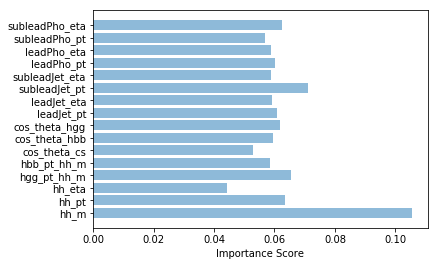

In [64]:
#features importance
clf=joblib.load('clf_point01.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [65]:
#reweighting and clipping it at 0.001
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,0.001)
w_train*=rw[y_train-1]

np.savetxt('rw_point001.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_point001.joblib') 

CPU times: user 1min 11s, sys: 1.29 s, total: 1min 12s
Wall time: 9.1 s


['clf_point001.joblib']

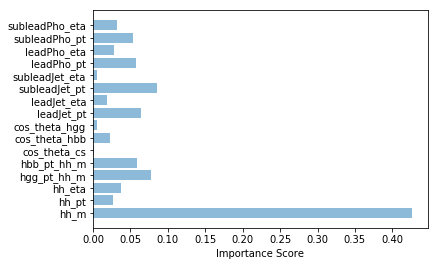

In [66]:
#features importance
clf=joblib.load('clf_point001.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [5]:
opt_accu=pd.read_hdf("optimisation_accu.hd5")
print "Best accuracy"
print opt_accu[0:3]

Best accuracy
    clip_weight  learning_rate  max_depth  n_estimators  reg_lambda  \
3          0.01            0.1          3           800        10.0   
46         0.01            0.1         10           300        10.0   
31         0.10            0.1          5           300        10.0   

    subsample  accu_mean  accu_stdev  cross_mean  cross_stdev  
3         0.6   0.560097    0.003229    1.199105     0.012119  
46        1.0   0.558570    0.005272    1.202164     0.011437  
31        1.0   0.556116    0.005174    1.199843     0.013411  


In [6]:
opt_cross=pd.read_hdf("optimisation_cross.hd5")
print "Best entropy"
print opt_cross[0:3]

Best entropy
    clip_weight  learning_rate  max_depth  n_estimators  reg_lambda  \
3          0.01            0.1          3           800        10.0   
31         0.10            0.1          5           300        10.0   
46         0.01            0.1         10           300        10.0   

    subsample  accu_mean  accu_stdev  cross_mean  cross_stdev  
3         0.6   0.560097    0.003229    1.199105     0.012119  
31        1.0   0.556116    0.005174    1.199843     0.013411  
46        1.0   0.558570    0.005272    1.202164     0.011437  


In [9]:
#optimized

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))
 
h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,0.01)
w_train*=rw[y_train-1]

np.savetxt('rw_opt.txt',rw)

clf=XGBClassifier(max_depth=3, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.6,
                 reg_lambda=10, learning_rate=0.1)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_opt.joblib') 

CPU times: user 6min 20s, sys: 6.8 s, total: 6min 27s
Wall time: 48.5 s


['clf_opt.joblib']

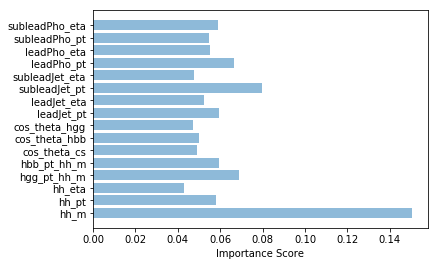

In [10]:
#features importance
clf=joblib.load('clf_opt.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()